In [ ]:
!pip install rdkit
!pip install networkx
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00


In [ ]:
import gdown
import pandas as pd
import torch
import numpy as np
from rdkit import Chem
from torch_geometric.data import Data, Batch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Load the CSV dataset
data = pd.read_csv('/content/drive/MyDrive/CS 566/Notebooks/catalyst.csv')
# data = pd.read_csv('/content/catalyst.csv')
print(data.shape)

Mounted at /content/drive
(1548, 10)


In [ ]:
def molecule_to_graph(molecule):
    num_atoms = molecule.GetNumAtoms()
    x = torch.tensor([atom_feature_vector(atom) for atom in molecule.GetAtoms()], dtype=torch.float)
    edge_index = []
    edge_attr = []
    for bond in molecule.GetBonds():
        edge_index.extend([[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()], [bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]])
        edge_attr.extend([bond_feature_vector(bond), bond_feature_vector(bond)])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

def atom_feature_vector(atom):
    return [atom.GetAtomicNum(), atom.GetDegree(), atom.GetHybridization()]

def bond_feature_vector(bond):
    return [bond.GetBondTypeAsDouble(), bond.IsInRing()]

def visualize(graph):
    nx_graph = to_networkx(graph, to_undirected=True)

    fig = plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(nx_graph)

    nx.draw_networkx(nx_graph, pos, with_labels=True, node_size=500, font_size=12, font_weight='bold')

    if 'edge_attr' in next(iter(nx_graph.edges(data=True)))[-1]:
        edge_labels = {(u, v): d['edge_attr'] for u, v, d in nx_graph.edges(data=True)}
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=10)

    plt.axis('off')
    plt.show()

In [ ]:
# Process each row of the dataset
graphs = []
indices = []
for _, row in data.iterrows():
    idx_dict = {}
    # Convert SMILES to molecule objects
    molecule1 = Chem.MolFromSmiles(row['Drug1'])
    molecule2 = Chem.MolFromSmiles(row['Drug2'])

    # Convert molecules to graph representations
    graph1 = molecule_to_graph(molecule1)
    graph2 = molecule_to_graph(molecule2)

    # Create the "Catalyst Score" node
    catalyst_score_features = torch.tensor([[
        row['CSS'],
        row['Synergy_ZIP'],
        row['Synergy_Bliss'],
        row['Synergy_Loewe'],
        row['Synergy_HSA'],
        row['Y']
    ]], dtype=torch.float)
    catalyst_score_node_index = graph1.x.shape[0] + graph2.x.shape[0]

    # Pad the node features of graph1 and graph2 to match the size of the "Catalyst Score" node features
    pad_size = catalyst_score_features.shape[1] - graph1.x.shape[1]
    graph1_x_padded = torch.cat([graph1.x, torch.zeros((graph1.x.shape[0], pad_size))], dim=1)
    graph2_x_padded = torch.cat([graph2.x, torch.zeros((graph2.x.shape[0], pad_size))], dim=1)

    # Combine the padded node features of graph1, graph2, and the "Catalyst Score" node
    combined_x = torch.cat([graph1_x_padded, graph2_x_padded, catalyst_score_features])

    combined_x_idx = [[], [], []]
    combined_x_idx[0] = np.arange(0,graph1.x.shape[0]) # graph 1 node indices
    combined_x_idx[1] = np.arange(graph1.x.shape[0],graph1.x.shape[0]+graph2.x.shape[0]) # graph 2 node indices
    combined_x_idx[2] = np.arange(graph1.x.shape[0]+graph2.x.shape[0],graph1.x.shape[0]+graph2.x.shape[0]+1) # y node index

    idx_dict["node"] = combined_x_idx

    # Create edges between each node in graph1 and the "Catalyst Score" node
    graph1_to_y_edge_index = torch.cat([
        torch.tensor([[i, catalyst_score_node_index] for i in range(graph1.x.shape[0])])
    ], dim=0).t().contiguous()

    '''
        Create edges between each node in graph2 and the "Catalyst Score" node. Note that a graph.x.shape[0] offset
        is required so that the edge indices are offset
    '''
    graph2_to_y_edge_index = torch.cat([
        torch.tensor([[i + graph1.x.shape[0], catalyst_score_node_index] for i in range(graph2.x.shape[0])])
    ], dim=0).t().contiguous()

    # Combine the edge indices
    combined_edge_index = torch.cat([graph1.edge_index, graph2.edge_index + graph1.x.shape[0], graph1_to_y_edge_index, graph2_to_y_edge_index], dim=1)

    combined_edge_index_idx = [[], [], []]
    combined_edge_index_idx[0] = np.arange(0,graph1.edge_index.shape[1]) # graph 1 edge index' indices
    combined_edge_index_idx[1] = np.arange(graph1.edge_index.shape[1],graph1.edge_index.shape[1]+graph2.edge_index.shape[1]) # graph 2 edge index' indices
    combined_edge_index_idx[2] = np.arange(graph1.edge_index.shape[1]+graph2.edge_index.shape[1],
                        graph1.edge_index.shape[1]+graph2.edge_index.shape[1]+graph1_to_y_edge_index.shape[1]+graph2_to_y_edge_index.shape[1]) # y edge index' index

    idx_dict["edge_index"] = combined_edge_index_idx

    # Edge connections from every other node to Y node
    graph1_to_y_edge_attr = torch.ones((graph1_to_y_edge_index.shape[1], graph1.edge_attr.shape[1]), dtype=torch.float)
    graph2_to_y_edge_attr = torch.ones((graph2_to_y_edge_index.shape[1], graph2.edge_attr.shape[1]), dtype=torch.float)

    # Combine the edge attributes
    combined_edge_attr = torch.cat([graph1.edge_attr, graph2.edge_attr, graph1_to_y_edge_attr, graph2_to_y_edge_attr])

    combined_edge_attr_idx = [[], [], []]
    combined_edge_attr_idx[0] = np.arange(0,graph1.edge_attr.shape[0]) # graph 1 edge attr' indices
    combined_edge_attr_idx[1] = np.arange(graph1.edge_attr.shape[0],graph1.edge_attr.shape[0]+graph2.edge_attr.shape[0]) # graph 2 edge attr' indices
    combined_edge_attr_idx[2] = np.arange(graph1.edge_attr.shape[0]+graph2.edge_attr.shape[0],
                        graph1.edge_attr.shape[0]+graph2.edge_attr.shape[0]+graph1_to_y_edge_attr.shape[0]+graph2_to_y_edge_attr.shape[0]) # y edge attr' index

    idx_dict["edge"] = combined_edge_attr_idx

    # Create the combined graph
    combined_graph = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y=catalyst_score_features)
    graphs.append(combined_graph)
    indices.append(idx_dict)

print(len(graphs))



1548


# Training

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
from torch_geometric.nn import GCNConv, NNConv, BatchNorm
from torch_geometric.data import Data

class SynergyGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_channels):
        super(SynergyGNN, self).__init__()
        self.conv1 = NNConv(in_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, in_channels * hidden_channels))
        self.bn1 = BatchNorm(hidden_channels)

        self.conv1b = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn1b = BatchNorm(hidden_channels)

        self.conv2 = NNConv(in_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, in_channels * hidden_channels))
        self.bn2 = BatchNorm(hidden_channels)

        self.conv2b = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn2b = BatchNorm(hidden_channels)

        self.conv3 = NNConv(hidden_channels, hidden_channels, nn=torch.nn.Linear(edge_channels, hidden_channels * hidden_channels))
        self.bn3 = BatchNorm(hidden_channels)

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def l2_regularization(self):
        l2_reg = 0
        for param in self.parameters():
            l2_reg += torch.sum(param ** 2)
        return l2_reg

    def forward(self, graph):
        v=graph.x
        edge_index = graph.edge_index
        e = graph.edge_attr
        indices = graph.indices

        v1 = v[torch.tensor(indices["node"][0][0])]
        v2 = v[torch.tensor(indices["node"][0][1])]

        e1 = e[torch.tensor(indices["edge"][0][0])]
        e2 = e[torch.tensor(indices["edge"][0][1])]
        e3 = e[torch.tensor(indices["edge"][0][2])]

        eidx1 = edge_index[:, torch.tensor(indices["edge_index"][0][0])]
        eidx2 = torch.sub(edge_index[:, torch.tensor(indices["edge_index"][0][1])], v1.shape[0])
        eidx3 = edge_index[:, torch.tensor(indices["edge_index"][0][2])]

        graph1 = self.conv1(v1, eidx1, e1)
        graph1 = self.bn1(graph1)
        graph1 = torch.nn.functional.elu(graph1)

        graph1 = self.conv1b(graph1, eidx1, e1)
        graph1 = self.bn1b(graph1)
        graph1 = torch.nn.functional.elu(graph1)

        graph2 = self.conv2(v2, eidx2, e2)
        graph2 = self.bn2(graph2)
        graph2 = torch.nn.functional.elu(graph2)

        graph2 = self.conv2b(graph2, eidx2, e2)
        graph2 = self.bn2b(graph2)
        graph2 = torch.nn.functional.elu(graph2)

        combined_nodes = torch.cat((graph1, graph2, torch.zeros(1, graph1.shape[1])), dim=0)
        v3 = self.conv3(combined_nodes, eidx3, e3)
        v3 = self.bn3(v3)
        v3 = torch.nn.functional.elu(v3)
        v3 = self.dropout(v3[-1])

        v3 = self.fc1(v3)
        v3 = torch.nn.functional.elu(v3)

        v3 = self.fc2(v3)
        v3 = torch.nn.functional.elu(v3)

        return v3

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import KFold

# Assuming 'graphs' and 'indices' are provided somewhere in your code
data = []
for graph, index in zip(graphs, indices):
    graph.indices = index
    data.append(graph)

# Define the number of folds for k-fold cross-validation
num_folds = 5

# Create a KFold object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=24)

# Define model, optimizer, and loss function
model = SynergyGNN(in_channels=6, hidden_channels=40, out_channels=6, edge_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
l2_weight = 0.01
loss_fn = torch.nn.MSELoss()

def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2

num_epochs = 40
patience = 10  # Number of epochs to wait for improvement

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
    print(f"Fold {fold+1}/{num_folds}")

    # Split the data into train and validation sets for the current fold
    train_dataset = [data[i] for i in train_idx]
    val_dataset = [data[i] for i in val_idx]

    # Create DataLoaders for train and validation sets
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(num_epochs):
      model.train()
      total_train_loss = 0
      train_preds, train_targets = [], []
      for graph in train_loader:
          output = model(graph)
          loss = loss_fn(output, graph.y.float()) + model.l2_regularization()
          optimizer.zero_grad()
          loss.backward()
          with torch.no_grad():
                optimizer.step()
          total_train_loss += loss.item()
          train_preds.append(output.detach())
          train_targets.append(graph.y.detach())

      train_preds = torch.cat(train_preds).view(-1, 6)
      train_targets = torch.cat(train_targets)
      train_r2 = r2_score(train_targets, train_preds)
      train_loss = total_train_loss / len(train_loader.dataset)

      model.eval()
      total_val_loss = 0
      val_preds, val_targets = [], []
      with torch.no_grad():
        for graph in val_loader:
            output = model(graph)
            loss = loss_fn(output, graph.y.float())
            total_val_loss += loss.item()
            val_preds.append(output.detach())
            val_targets.append(graph.y.detach())

      val_preds = torch.cat(val_preds).view(-1, 6)
      val_targets = torch.cat(val_targets)
      val_r2 = r2_score(val_targets, val_preds)
      val_loss = total_val_loss / len(val_loader.dataset)

      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train R2: {train_r2:.4f}, Val Loss: {val_loss:.4f}, Val R2: {val_r2:.4f}')

      # Early stopping
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          counter = 0
      else:
          counter += 1
          if counter >= patience:
              print(f"Early stopping at epoch {epoch+1}")
              break

    print()

Fold 1/5
Epoch 1/40, Train Loss: 2858.9978, Train R2: 0.1844, Val Loss: 355.1155, Val R2: 0.3627
Epoch 2/40, Train Loss: 1776.4551, Train R2: 0.5383, Val Loss: 307.0574, Val R2: 0.4489
Epoch 3/40, Train Loss: 1229.6545, Train R2: 0.5494, Val Loss: 347.4532, Val R2: 0.3764
Epoch 4/40, Train Loss: 942.4047, Train R2: 0.5530, Val Loss: 400.5676, Val R2: 0.2811
Epoch 5/40, Train Loss: 786.5173, Train R2: 0.5553, Val Loss: 529.6304, Val R2: 0.0495
Epoch 6/40, Train Loss: 698.6627, Train R2: 0.5587, Val Loss: 876.6378, Val R2: -0.5733
Epoch 7/40, Train Loss: 645.8821, Train R2: 0.5630, Val Loss: 560.2672, Val R2: -0.0055
Epoch 8/40, Train Loss: 612.0567, Train R2: 0.5651, Val Loss: 1130.7765, Val R2: -1.0294
Epoch 9/40, Train Loss: 589.2012, Train R2: 0.5671, Val Loss: 1948.2123, Val R2: -2.4965
Epoch 10/40, Train Loss: 576.2357, Train R2: 0.5651, Val Loss: 1951.7492, Val R2: -2.5028
Epoch 11/40, Train Loss: 563.1713, Train R2: 0.5675, Val Loss: 1557.3131, Val R2: -1.7949
Epoch 12/40, Train 

In [ ]:
import pickle

with open('catalyst_model.pkl', 'wb') as f:

    pickle.dump(model, f)

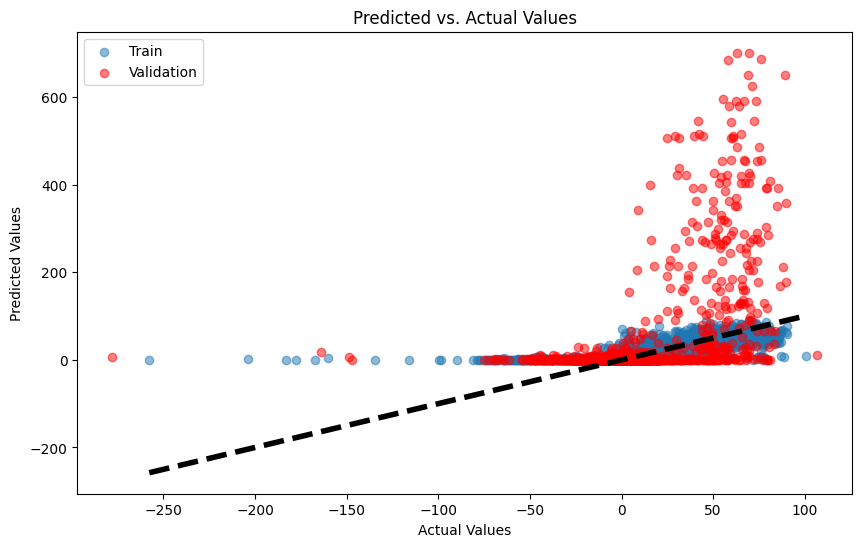

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_targets.numpy(), train_preds.numpy(), alpha=0.5, label='Train')
plt.scatter(val_targets.numpy(), val_preds.numpy(), color='red', alpha=0.5, label='Validation')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=4)
plt.show()

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import numpy as np

data = []
for graph, index in zip(graphs, indices):
    graph.indices = index
    data.append(graph)

# dataset = CustomGraphDataset(graphs, indices)
loader = DataLoader(data, batch_size=1, shuffle=True)

# Define model, optimizer, and loss function
model = SynergyGNN(in_channels=6, hidden_channels=8, out_channels=6, edge_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for graph in loader:
        # Forward Pass
        output = model(graph)
        loss = loss_fn(output, graph.y.float())

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        '''
        for name, param in model.named_parameters():
          if param.requires_grad and total_loss < 0.01 and name == 'conv1.nn.weight':
            print(f"Gradient for {name}: {param.grad}")
        '''

        with torch.no_grad():
          optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}')


Epoch 1/10, Loss: 669.4192
Epoch 2/10, Loss: 640.9284
Epoch 3/10, Loss: 621.0291
Epoch 4/10, Loss: 601.8801
Epoch 5/10, Loss: 580.5180
Epoch 6/10, Loss: 558.3860
Epoch 7/10, Loss: 540.6452
Epoch 8/10, Loss: 518.0442
Epoch 9/10, Loss: 493.8528
Epoch 10/10, Loss: 487.2744
